# **MarkNet**

## Optical Character Recognition (OCR) Sequence-to-Sequence (Seq2Seq) Model


#### **Installing YOLOv8 (Ultralytics) and TorchInfo**
The **Ultralytics** library provides the official implementation of **YOLOv8**, one of the most advanced object detection models.
Trochinfo is used for print details.

In [ ]:
!pip install ultralytics --quiet
!pip install torchinfo --quiet

#### **Mount Google Drive**

This cell mounts your Google Drive to Colab, allowing access to files stored in your Drive.  


In [4]:
from google.colab import drive
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **1. Importing Required Libraries**

**General Python Libraries**
- **os** – Handles file paths, directories, and environment operations.  
- **re** – Pattern matching in text using regular expressions.  
- **cv2 (OpenCV)** – Image processing (read, resize, crop, filter).  
- **glob** – Searches file paths using patterns (e.g., `*.jpg`).  
- **math** – Standard mathematical functions.  
- **yaml** – Loads and reads YAML configuration files.  
- **random** – Random selections, shuffling, stochastic training behavior.  
- **shutil** – Copying, moving, deleting files/folders.



 **Machine Learning / Deep Learning Libraries**
- **torch** – Core PyTorch library for tensors and deep learning.  
- **torch.nn** – Neural network layers (Conv, Linear, LSTM, etc.).  
- **torch.optim** – Optimizers such as Adam, SGD.  
- **torch.nn.functional (F)** – Activation, loss functions, etc.  
- **torch.utils.data (Dataset, DataLoader, Subset)** – Handling datasets and batching.



**ML Utility Libraries**
- **editdistance** – Computes string distance for OCR accuracy evaluation.  
- **pandas (pd)** – Tabular data handling and CSV processing.  
- **numpy (np)** – Numerical arrays, matrices, vectorized math.  
- **sklearn.model_selection** – Tools like `train_test_split`, `KFold`.


**Computer Vision & Image Handling**
- **torchvision.transforms** – Resize, normalize, augment images.  
- **PIL (Image, ImageEnhance, ImageFilter, etc.)** – Opening, editing, enhancing images.



**YOLO (Object Detection)**
- **from ultralytics import YOLO** – Loads YOLOv8/YOLOv9 models for detection.



**Visualization**
- **matplotlib.pyplot** – Plot graphs, metrics, images.  
- **seaborn** – Attractive statistical plots.  
- **IPython.display** – Display images and outputs in notebooks.



**Custom Utility Files**
- **load_checkpoint** – Loads saved model states.  
- **save_checkpoint** – Saves model states.

**utils – Custom helper functions:**
- `copy_data`
- `ResizePad`
- `detect_and_crop`  
- `plot_roc_and_confusion`  
- `visualize_crops_with_labels`  



In [ ]:
import sys
if 'utils' in sys.modules:
    del sys.modules['utils']

In [5]:
# Imports
import os, re, cv2, glob, math, yaml, random, shutil
import torch
import editdistance
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import defaultdict

from datetime import datetime
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchinfo import summary
from PIL import Image, ImageEnhance, ImageFilter, ImageDraw, ImageFont

from sklearn.model_selection import train_test_split, KFold
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Image as DisplayImage


# Custom utils
from checkpoint_utils import load_checkpoint, save_checkpoint
from utils import ResizePad, copy_data, detect_and_crop, plot_roc_and_confusion , fix_date_format, visualize_crops_with_labels
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda


## **PART 1: YOLO — ROI Detection Model**

####  **1. Load Dataset**
This code goes through the main dataset folder and collects all image file paths (both `.jpg` and `.png`) from its subfolders.




In [ ]:
# base directory to store data
base_dir = "/content/data"
source_dir = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/dataset_/Marksheets_robo"
os.makedirs(base_dir, exist_ok=True)

# Get all image paths
image_paths = glob.glob(os.path.join(source_dir, "*", "images", "*.jpg"))
print(f"Found {len(image_paths)} images")

Found 740 images


#### **3. Explore the dataset**

##### **Visualize Random Images**
Randomly display three sample images side-by-side using Matplotlib to quickly visualize the dataset.

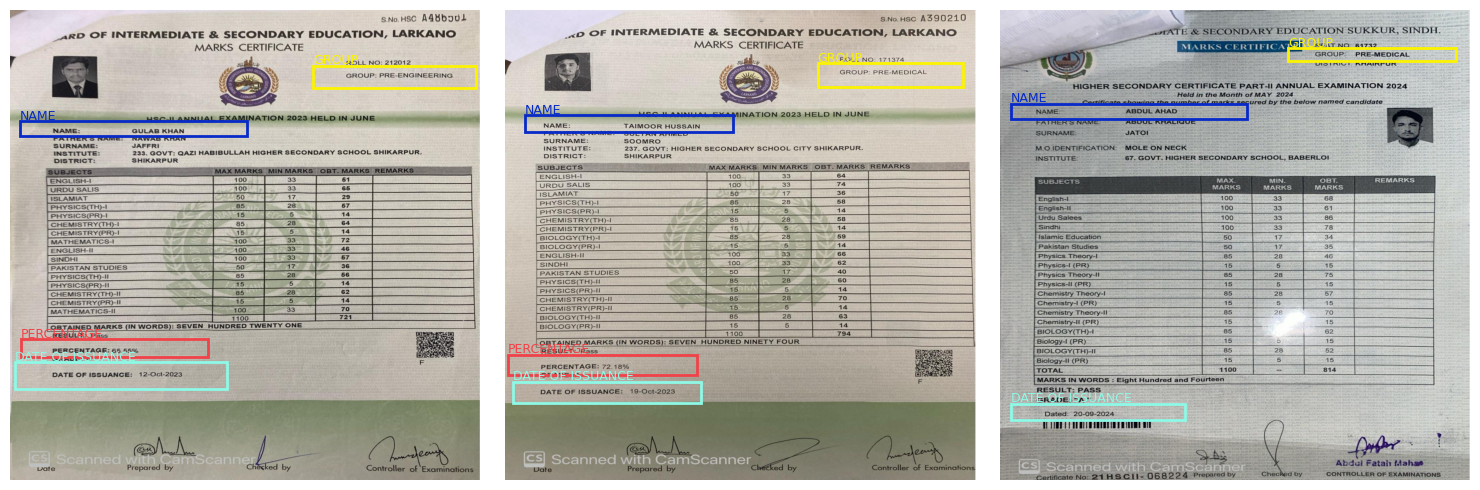

In [ ]:
# Visualize 3 random training images with YOLO labels

CLASS_NAMES = ["DATE OF ISSUANCE", "GROUP", "NAME", "PERCENTAGE"]
COLORS = ["#8df9e6",  "#fcf300",  "#072ac8","#f04248"]
          # Sea Green  Yellow       # Blue   Red

# Select Random Sample
samples = random.sample(image_paths, 3)
plt.figure(figsize=(15, 5))

# Loop through
for i, img_path in enumerate(samples):
    img = Image.open(img_path)
    w, h = img.size
    ax = plt.subplot(1, 3, i+1)
    ax.imshow(img); ax.axis("off")

    label_path = img_path.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
    if not os.path.exists(label_path): continue

    # Loop on .text(lables)
    for line in open(label_path):
        cls, x, y, bw, bh = map(float, line.split())
        x, y, bw, bh = x*w, y*h, bw*w, bh*h
        xmin, ymin = x - bw/2, y - bh/2

        ax.add_patch(plt.Rectangle((xmin, ymin), bw, bh, fill=False,
                                   color=COLORS[int(cls)], linewidth=2))
        ax.text(xmin, ymin-4, CLASS_NAMES[int(cls)],
                color=COLORS[int(cls)], fontsize=9)

# Plot Images
plt.tight_layout()
plt.show()


##### **Class Distribution of YOLO Labels**

To understand how balanced the dataset is, we count how many annotations exist for each class:

- **DATE OF ISSUANCE**  
- **GROUP**  
- **NAME**  
- **PERCENTAGE**

A bar chart is used to visualize the frequency of each label. This helps identify whether the dataset is skewed toward any class, which can affect model performance.


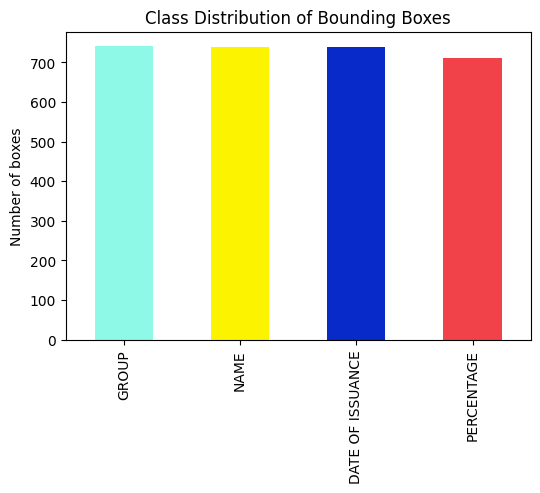

In [ ]:
# Collect class info from labels
classes = []
for img_path in image_paths:
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls = int(line.strip().split()[0])
                classes.append(CLASS_NAMES[cls])

# Plot class distribution
plt.figure(figsize=(6,4))
pd.Series(classes).value_counts().plot(kind='bar', color=COLORS)
plt.title("Class Distribution of Bounding Boxes")
plt.ylabel("Number of boxes")
plt.show()

#### **4. Split the dataset into a train/val/test split. yaml**

This step splits the dataset and generates the `data.yaml` file required for YOLOv8.

1. This cell divides the dataset into:

   * **70% for training** (used to train the model)

   * **20% for validation** (used to tune the model during training)

   * **10% for testing** (used to check final performance)

2. It then creates a data.yaml file that includes:
   * Total 4 classes **ROIs** (Region of Intresets), labeled as:
   
        1️⃣ DATE OF ISSUANCE

        2️⃣ GROUP

        3️⃣ NAME
    
        4️⃣ PERCENTAGE

Each image has a `.txt` file with 4 lines (one for each ROI):

`class_id  x_center  y_center  width  height`

`0  0.52  0.43  0.20  0.10`


In [ ]:
# Split dataset
train, temp = train_test_split(image_paths, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.33, random_state=42)

# Create folder structure
for split in ["train","val","test"]:
    for sub in ["images","labels"]:
        os.makedirs(os.path.join(base_dir, split, sub), exist_ok=True)

# Copy split data into folders(train, val, test)
for split, paths in zip(["train","val","test"], [train,val,test]):
    copy_data(paths, split, base_dir)

# Save YAML
yaml_path = os.path.join(base_dir, "data.yaml")
yaml.dump({
    "train": f"{base_dir}/train/images",
    "val":   f"{base_dir}/val/images",
    "test":  f"{base_dir}/test/images",
    "nc": 4,
    "names": ["DATE OF ISSUANCE","GROUP","NAME","PERCENTAGE"]
}, open(yaml_path,"w"))

# Total Images
total = len(train) + len(val) + len(test)

print("✅ Dataset prepared successfully!")
print(f"Train: {len(train)} images ({len(train)/total*100:.2f}%)")
print(f"Val:   {len(val)} images ({len(val)/total*100:.2f}%)")
print(f"Test:  {len(test)} images ({len(test)/total*100:.2f}%)")
print(f"YAML file saved at: {yaml_path}")

✅ Dataset prepared successfully!
Train: 518 images (70.00%)
Val:   148 images (20.00%)
Test:  74 images (10.00%)
YAML file saved at: /content/data/data.yaml


#### **5. Build model**
This cell trains the **YOLOv8n (Nano)** model, which is the smallest and fastest version of YOLOv8 — ideal for lightweight datasets and quick training.


In [ ]:
data_yaml = "/content/data/data.yaml"

# Initialize the Model
yolo_model = YOLO("yolov8n.pt")

#### **6. Train the model**
It runs for **50 epochs** with an image size of **640** and **batch size 16** on the GPU.`

In [ ]:
# Train
yolo_model.train(
    data=data_yaml,
    epochs=100,
    imgsz=640,
    batch=16,
    device=DEVICE,
    project='/content/drive/MyDrive/Colab Notebooks',
    name="marksheet_yolo_model",
    verbose=False
)

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=marksheet_yolo_model2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d7adb265760>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

#### **7. Plot Learning Curve**

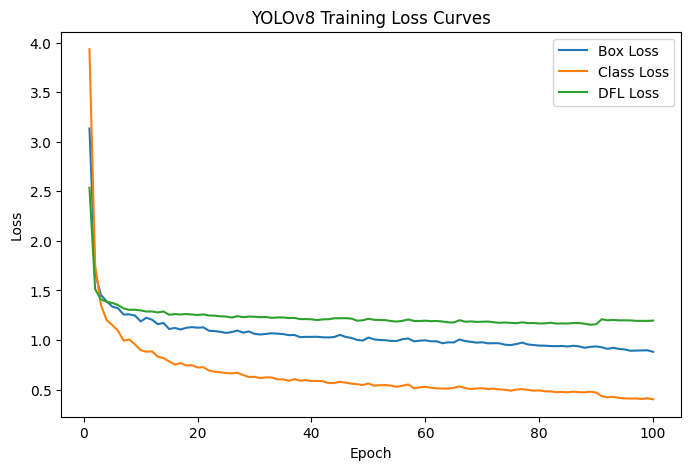

In [ ]:
# Get Results of Yolo
results_csv = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/dataset_/marksheet_yolo_model_v1/results.csv"
df = pd.read_csv(results_csv)

# Plot training curve
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("YOLOv8 Training Loss Curves")
plt.legend()
plt.grid(False)
plt.show()


#### **8. Prediction of test data**

In [26]:
# Load trained model
yolo_best_model = YOLO("/content/drive/MyDrive/Colab Notebooks/dataset_/marksheet_yolo_model_v1/weights/best.pt")

# Test folder
test_folder = "/content/data/test/images"
output_dir = "/content/crops"
os.makedirs(output_dir, exist_ok=True)

label_names = ['DATE OF ISSUANCE', 'GROUP', 'NAME', 'PERCENTAGE']

# Pick one random image from test set
test_images = glob.glob(f"{test_folder}/*.jpg")
random_image = random.choice(test_images)

print("Testing on image:", random_image)

# Load and run detection
img = Image.open(random_image).convert("RGB")  # Ensures consistent input & correct format
results = yolo_best_model(random_image, conf=0.4, verbose=False)

# Crop detected regions
crops = []
for box in results[0].boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    cls = int(box.cls.item())

    crop = img.crop((x1, y1, x2, y2))

    crop_name = f"{os.path.basename(random_image).split('.')[0]}_{label_names[cls]}.jpg"
    crop_path = os.path.join(output_dir, crop_name)
    crop.save(crop_path)

    crops.append((crop_path, label_names[cls]))

# Show results
print("\nCropped Outputs:")
for crop_path, label in crops:
    plt.imshow(Image.open(crop_path))
    plt.title(label)
    plt.axis("off")
    plt.show()

#### **10. Model Evaluation**

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2685.3±1555.1 MB/s, size: 248.0 KB)
val: Scanning /content/data/test/labels... 74 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 74/74 2.5Kit/s 0.0s
val: New cache created: /content/data/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.1it/s 4.4s
                   all         74        293      0.983      0.986      0.988      0.724
      DATE OF ISSUANCE         74         74      0.986      0.986      0.982       0.65
                 GROUP         74         74      0.986      0.973      0.986      0.729
                  NAME         74         74          1      0.986      0.992      0.767
            PERCENTAGE         71         71      0.959          1      0.994      0.748
Speed: 6.2ms preprocess, 8.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Resul

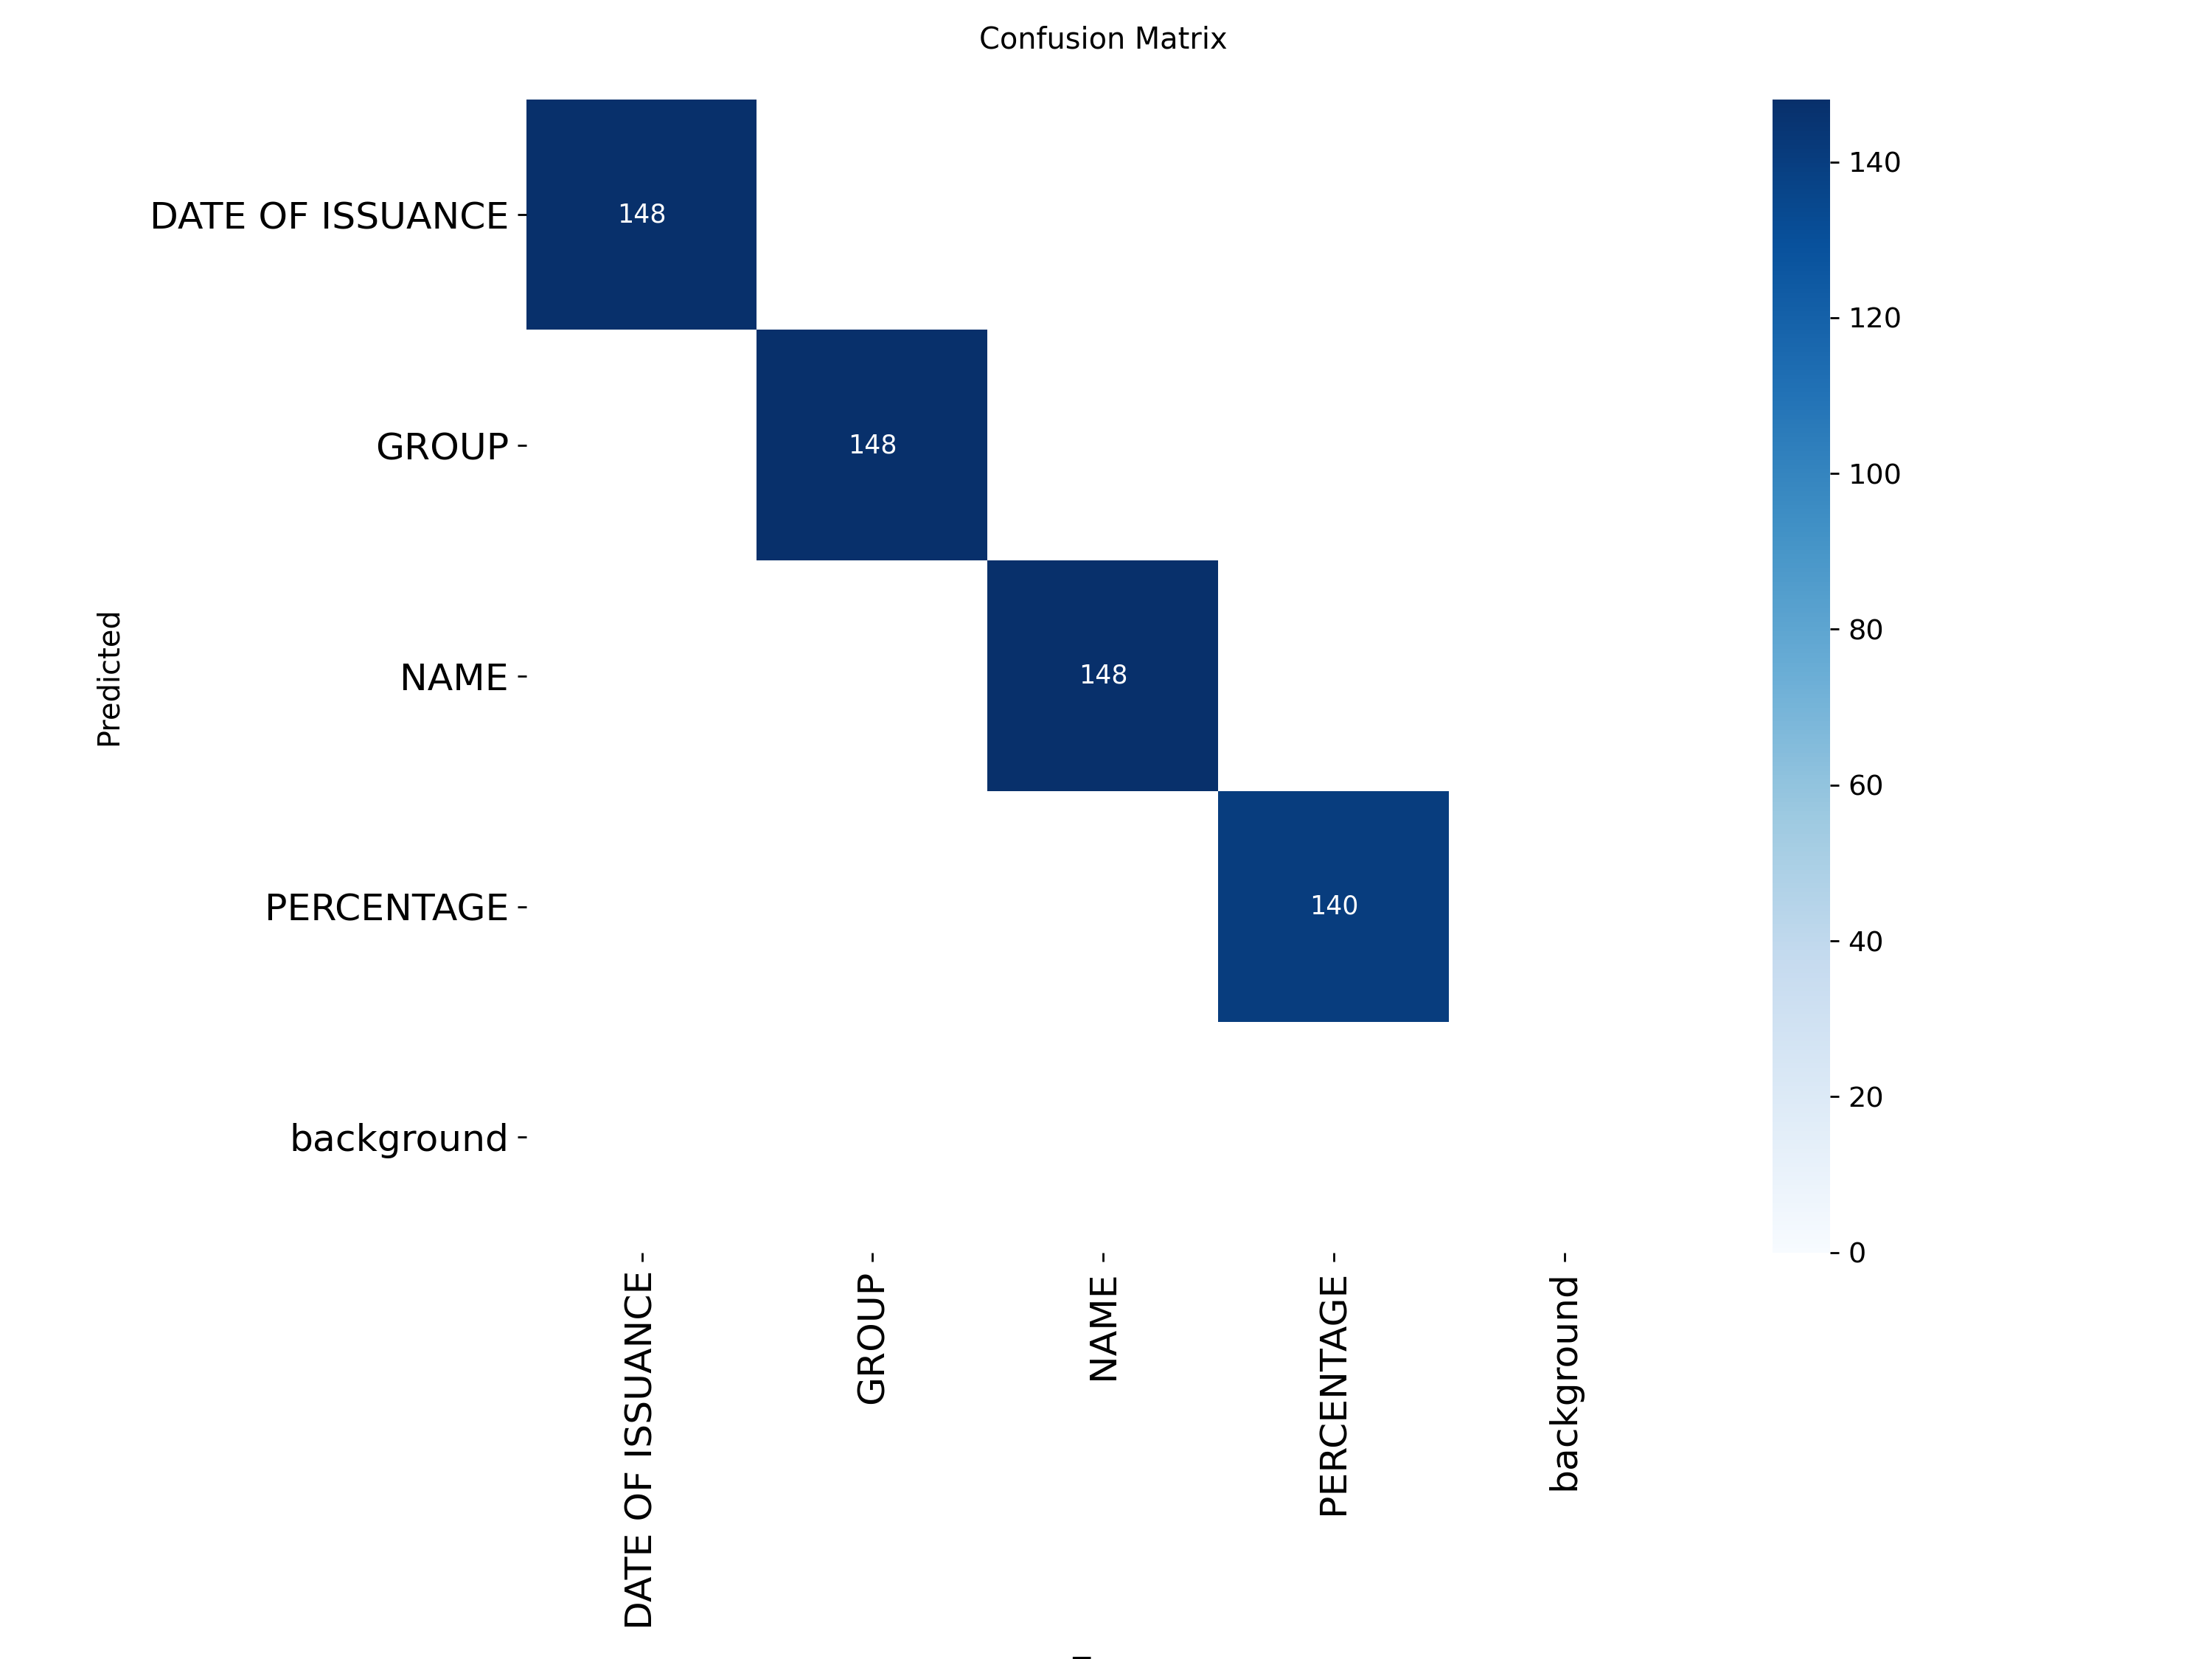

Results Summary (includes PR curves and metrics):


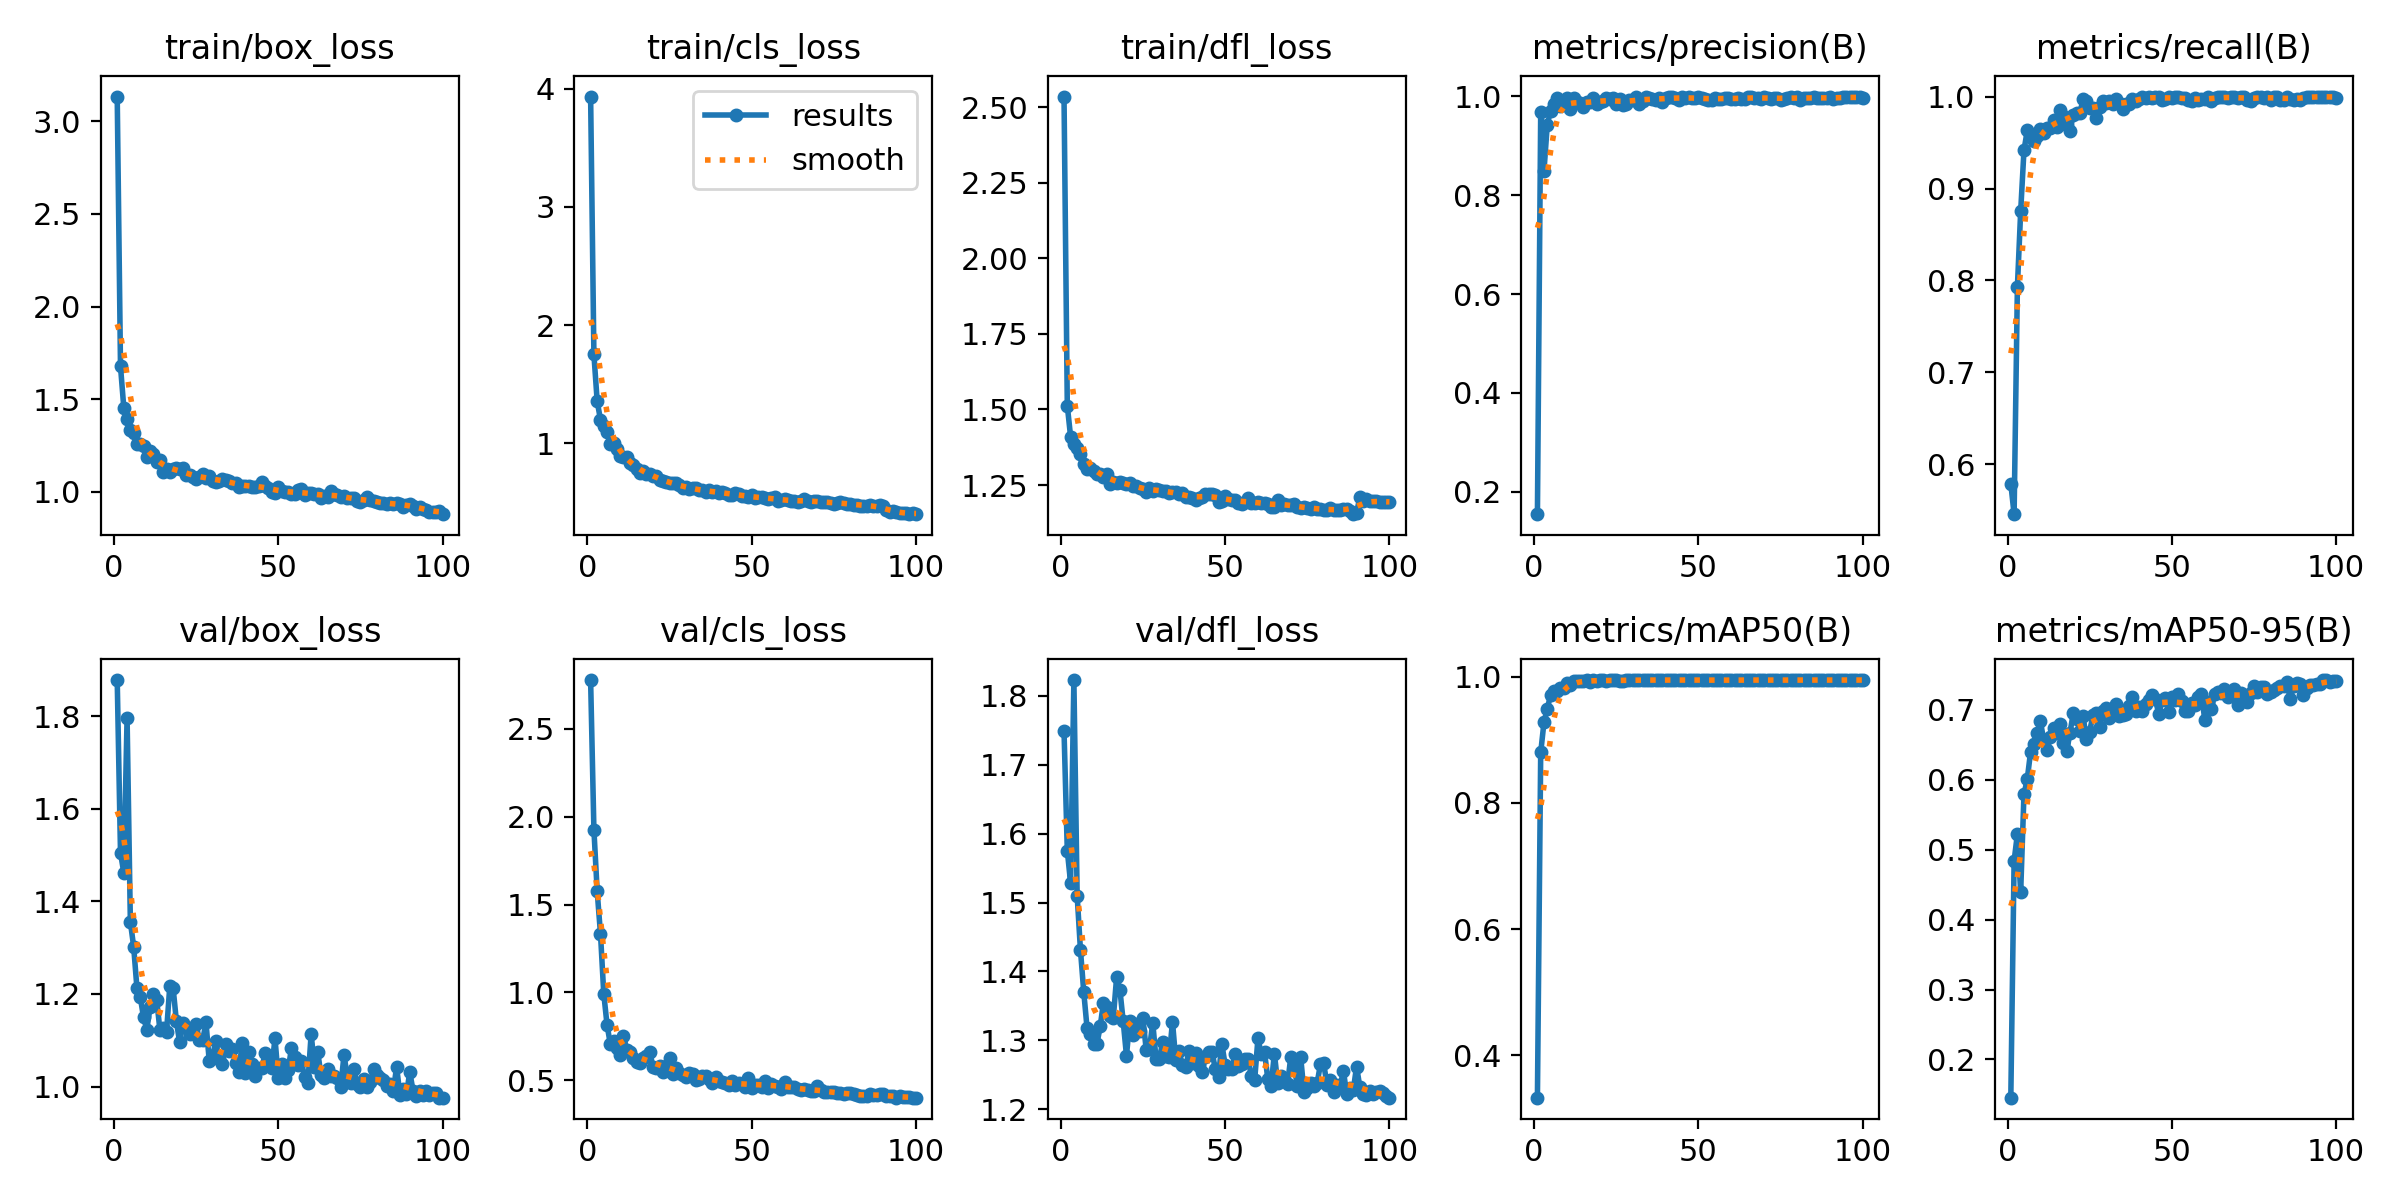

In [ ]:
# YOLOv8 Model Evaluation on test set
results = yolo_best_model.val(data=data_yaml, imgsz=640, conf=0.25, split="test")

# Overall metrics
print("\n\n\✅ YOLOv8 Test Set Evaluation Metrics:")
metrics = results.results_dict
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Per-class summary
print("\nPer-class performance summary:")
results.summary()  # prints precision, recall, mAP per class

# Paths
base_path = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/dataset_/marksheet_yolo_model_v1"
res_path = os.path.join(base_path, "results.png")
cm_path = os.path.join(base_path, "confusion_matrix.png")

# Display images
print("Confusion Matrix:")
display(DisplayImage(filename=cm_path))

# Display results image (loss curves, precision, recall, mAP)
print("Results Summary (includes PR curves and metrics):")
display(DisplayImage(filename=res_path))

## **PART 2: CRNN**

### **1. Load Data CRNN**

Read images and labels, filenames, and merge them into one DataFrame.

In this step, we:
* Define folder paths for images and CSV label files.  
* Read and combine all CSV files containing image labels.  
* Collect all image file paths from subfolders.  
* Match image paths with their corresponding labels.  
* Fix short date formats (e.g., `21-Oct-23 → 21-Oct-2023`).  
* Create a final combined dataframe (`merged_df`) with both image paths and their text labels, ready for training.


In [7]:
# Paths
CSV_DIR = "/content/drive/MyDrive/Colab Notebooks/dataset_/Cropped_labels"
IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/dataset_/Marksheets_cropped"

# Read all CSV files
csv_files = glob.glob(os.path.join(CSV_DIR, "*.csv"))

# Loop on CSVs
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

# Make filenames lowercase for matching
df["image_filename"] = df["image_filename"].str.lower().str.strip()

# Collect All Images
image_paths = []
for root, _, files in os.walk(IMG_DIR):
    for f in files:
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(root, f)
            image_paths.append(full_path)

# Create a dataframe for image paths
img_df = pd.DataFrame({
    "image_path": image_paths,
    "image_filename": [os.path.basename(p).lower() for p in image_paths]
})

# MERGE
merged_df = pd.merge(df, img_df, on="image_filename", how="inner")

# Correct Date format
mask = merged_df["label"].str.strip().str.upper().eq("DATE OF ISSUANCE")
merged_df.loc[mask, "text"] = merged_df.loc[mask, "text"].apply(fix_date_format)

print("Total CSV rows:", len(df))
print("Total image paths found:", len(img_df))
print("Matched rows:", len(merged_df))

merged_df.head()

Total CSV rows: 2927
Total image paths found: 2926
Matched rows: 2926


,image_filename,label,text,image_path
0,ahdq4664_jpg.rf.996c4a74bb4a6d25f779d1d576b916...,DATE OF ISSUANCE,12-Oct-2023,/content/drive/MyDrive/Colab Notebooks/dataset...
1,ahdq4664_jpg.rf.996c4a74bb4a6d25f779d1d576b916...,GROUP,PRE-ENGINEERING,/content/drive/MyDrive/Colab Notebooks/dataset...
2,ahdq4664_jpg.rf.996c4a74bb4a6d25f779d1d576b916...,NAME,KASHIF ALI,/content/drive/MyDrive/Colab Notebooks/dataset...
3,ahdq4664_jpg.rf.996c4a74bb4a6d25f779d1d576b916...,PERCENTAGE,88.55%,/content/drive/MyDrive/Colab Notebooks/dataset...
4,aixn4194_jpg.rf.d04a0a0f4465ff5a62176b06ae23ee...,DATE OF ISSUANCE,12-Oct-2023,/content/drive/MyDrive/Colab Notebooks/dataset...


### **2. Explore the dataset**

#### **Visualize Random Images**

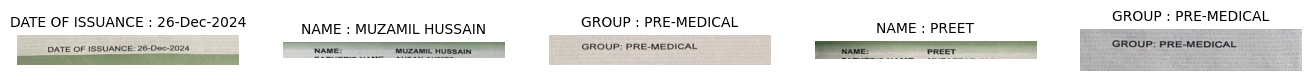

In [8]:
# Pick 5 random samples
samples = merged_df.sample(5)

plt.figure(figsize=(20, 4))

for i, (_, row) in enumerate(samples.iterrows(), 1):
    plt.subplot(2, 6, i)
    img = Image.open(row["image_path"])
    plt.imshow(img)
    plt.title(f"{row['label']} : {row['text']}", fontsize=10)
    plt.axis("off")
# Show
plt.show()

#### **Class Distribution Plot**

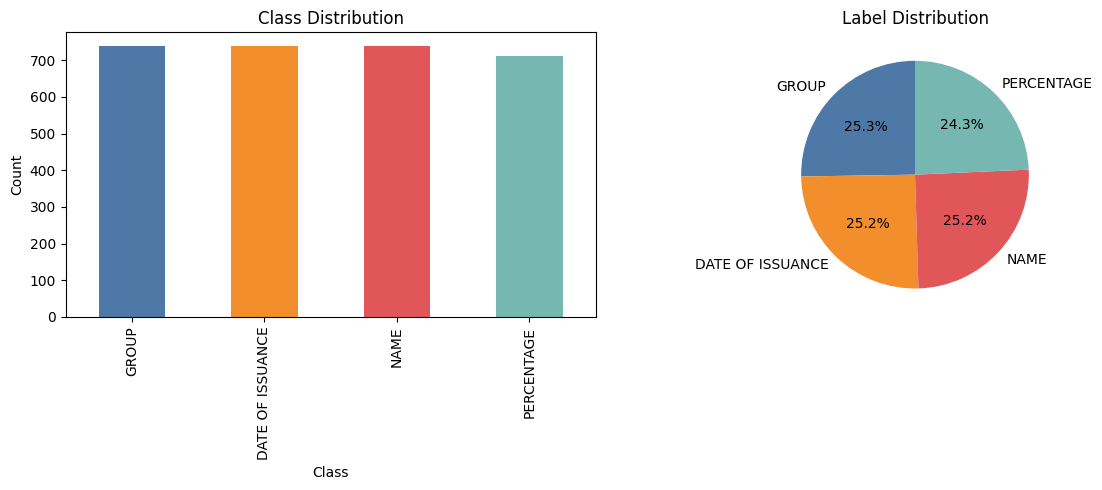

In [9]:
# conunt classes
counts = merged_df['label'].value_counts()

# color palette
colors = ["#4e79a7", "#f28e2b", "#e15759", "#76b7b2", "#59a14f", "#edc948"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
counts.plot(kind='bar', ax=axes[0], color=colors[:len(counts)])
axes[0].set_title("Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# Pie chart
counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90, colors=colors[:len(counts)])
axes[1].set_title("Label Distribution")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


### **3. Preprocessing**

#### **Build Vocabulary**

* Define a **default character set** for OCR (letters, digits, and common symbols).  
* Use the **merged dataframe** to extract label–text pairs from each cropped ROI image.  
* Build a **vocabulary** from all unique characters appearing in these labels and texts.  


In [10]:
# vocabulary
DEFAULT_CHARS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.-/%:|, "

pivot_df = merged_df.pivot_table(
    index="image_filename",
    columns="label",
    values="text",
    aggfunc="first"
).reset_index()

# Fill missing values with empty strings
pivot_df = pivot_df.fillna("")

# Build combined text for each image
merged_df["text"] = merged_df.fillna("").apply(
    lambda r: f"{str(r['label']).strip().upper()}: {str(r['text']).strip().upper()}",
    axis=1
)

# Make uppercase for consistency
all_text = " ".join(merged_df["text"].tolist()).upper()
vocab = sorted(set(all_text + DEFAULT_CHARS))

print("Vocab size:", len(vocab))

# Build character mappings
char_to_idx = {c: i + 1 for i, c in enumerate(vocab)}  # Converts characters → numbers
idx_to_char = {i + 1: c for i, c in enumerate(vocab)}  #Converts numbers → characters

Vocab size: 44


#### **Text Encoding + Decoding**

* Create **character-to-index** and **index-to-character** mappings for encoding and decoding.  
* Define helper functions:  
  - `encode_text()` → Converts text into numeric sequences.  
  - `decode_indices()` → Converts numeric predictions back into readable text.


In [11]:
# Encode Text
def encode_text(s):
    return [char_to_idx[c] for c in s.upper() if c in char_to_idx]

# Decode Text
def decode_indices(seq):
    out, prev = [], None
    for i in seq:
        if i != prev and i != 0:
            out.append(idx_to_char[i])
        prev = i
    return "".join(out)

# Decode Fields
field_names = sorted(list(set(merged_df["label"].astype(str).str.strip().tolist())))

field_to_idx = {f: i for i, f in enumerate(field_names)}
idx_to_field = {i: f for f, i in field_to_idx.items()}

print("Field classes:", field_to_idx)

Field classes: {'DATE OF ISSUANCE': 0, 'GROUP': 1, 'NAME': 2, 'PERCENTAGE': 3}


#### **Image Preprocessing**

All images are processed to a fixed size of **64 × 512** using a custom `ResizePad()` transform.  
This preserves aspect ratio and pads the remaining area.

---

##### **Training Transformations**

1. **Grayscale**  
   Converts the image to a single channel.

2. **Resize + Pad (64×512)**  
   Maintains aspect ratio and pads to the target size.

3. **Random Rotation (±3°)**  
   Adds slight rotation to handle tilted or misaligned text.

4. **Color Jitter**  
   Applies small brightness and contrast variations.

5. **ToTensor**  
   Converts the image into a PyTorch tensor with values in the range [0, 1].

6. **Normalize**  
   Normalizes pixel values using `(x - 0.5) / 0.5`, mapping them to [-1, 1].


##### **Test / Validation Transformations**

1. Grayscale  
2. Resize + Pad (same as training)  
3. ToTensor  
4. Normalize  


In [12]:
# Image Size
IMG_HEIGHT, IMG_WIDTH = 64, 512

# Train Transfrom
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Converts image to grayscale
    ResizePad(),                                   # Resizes image
    transforms.RandomRotation(3, fill=255),          # small rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # slight brightness/contrast change
    transforms.ToTensor(),                         # Converts image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Centers pixel values
])


# Test/Validation transforms
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # Converts image to grayscale
    ResizePad(),                                # Resizes image
    transforms.ToTensor(),                      # Converts image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Centers pixel values
])



#### **Data Augmentation**

- **`RandomAug`** → Performs light data augmentation such as rotation, brightness, contrast, and blur.

In [13]:
# Augmentation
class RandomAug:
    # takes numpy image
    def __call__(self, img_np):
        img = Image.fromarray(img_np) # Converts a NumPy array into a PIL Image.
        img = img.rotate(random.uniform(-2, 2), resample=Image.BICUBIC) # Slight random rotation
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.95, 1.05)) # Random brightness variation.
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.95, 1.05))  # Random contrast adjustment
        if random.random() < 0.2:
            img = img.filter(ImageFilter.GaussianBlur(random.uniform(0, 0.8))) # Applies blur
        return np.array(img)

#### **Helper Functions**

**1. `character_accuracy(gts, preds)`**
Computes **character-level accuracy** by comparing each character in the predicted string with the ground-truth string.

- Measures how many characters match correctly.
- Useful for fine-grained text recognition evaluation.


**2. `CER(gts, preds)` — *Character Error Rate***
Calculates the **edit distance** between predictions and ground truth:

- Lower CER = better model
- Accounts for insertions, deletions, substitutions.


**3. `string_accuracy(gts, preds)`**
Computes **exact-match accuracy**:

- Counts the percentage of predicted strings that match the ground truth **exactly**.
- Strict metric — no partial credit.



**4. `field_accuracy(fields, gts, preds)`**
Computes accuracy **per field** (e.g., `"NAME"`, `"DATE"`, `"GROUP"`):

- Useful for structured OCR tasks.
- Helps identify which field the model struggles with.

**5. `decode_predictions(outputs)`**
Converts raw model outputs into readable text:

- Applies **CTC decoding**
- Removes **duplicate characters**
- Removes **blank tokens**
- Cleans noisy text  
  Example:  
  `"NAME: NAME:" → "NAME:"`

**6. `compute_accuracy(model, dataset, device)`**
Runs complete evaluation for a text recognition model:

1. Performs **model inference**
2. Decodes predictions using `decode_predictions`
3. Removes field prefixes (e.g., `"NAME:"`)
4. Computes:
   - Character accuracy  
   - CER  
   - String accuracy  
   - Per-field accuracy



In [14]:
# Character level Accuracy
def character_accuracy(gts, preds):
    total_chars = 0
    correct_chars = 0

    # Loop each GT & Pred string pair
    for gt, pred in zip(gts, preds):
        L = min(len(gt), len(pred))
        correct_chars += sum(gt[i] == pred[i] for i in range(L))
        total_chars += len(gt)
    # Return accuracy
    return correct_chars / total_chars if total_chars else 0

# Character Error Rate (CER)
def CER(gts, preds):

    # Total edit distance across predictions
    dist = sum(editdistance.eval(p, g) for p, g in zip(preds, gts))
    total_chars = sum(len(g) for g in gts)
    return dist / total_chars if total_chars else 0


# String-level (exact-match) accuracy
def string_accuracy(gts, preds):
    correct = sum(g == p for g, p in zip(gts, preds))
    return correct / len(gts) if gts else 0

# Field-specific accuracy (per label)
def field_accuracy(fields, gts, preds):
    stats = defaultdict(lambda: [0,0])

    for f, gt, pred in zip(fields, gts, preds):
        stats[f][1] += 1
        if gt == pred:
            stats[f][0] += 1

    return {f: c/t for f, (c,t) in stats.items()}


# Prediction Decoding
def decode_predictions(outputs):
    preds = outputs.argmax(2)
    texts = []
    for p in preds:
        prev = -1
        chars = []

         # CTC decoding skip duplicates + blank index 0
        for idx in p:
            idx = int(idx.item()) if isinstance(idx, torch.Tensor) else int(idx)
            if idx != prev and idx != 0:
                chars.append(idx_to_char.get(idx, ''))
            prev = idx
        text = "".join(chars).strip()

         # Remove repeated field prefixes (e.g., "NAME: NAME:")
        text = re.sub(r"\b([A-Z ]+:\s*)\1+", r"\1", text)

        texts.append(text)
    return texts

# Compute Accuracy for the entire dataset(used in train accuracy)
def compute_accuracy(model, dataset, device):
    gts, preds = [], []
    model.eval()

    # Disable gradient computation.
    with torch.no_grad():
        for i in range(len(dataset.df)):
            img, _ = dataset[i]
            image = img.unsqueeze(0).to(device).float()

            # Prediction
            output = F.log_softmax(model(image), dim=2)
            pred = decode_predictions(output.cpu())[0].upper().strip()

            # Ground truth and label
            row = dataset.df.iloc[i]
            field = str(row.get("label", "")).upper().strip()
            gt = str(row.get("text", "")).upper().strip()

            # Clean both
            gt = re.sub(rf"^{field}\s*[:\-]?\s*", "", gt).strip()
            pred = re.sub(rf"^{field}\s*[:\-]?\s*", "", pred).strip()

            # Normalize characters
            gt = re.sub(r"[^A-Z0-9%:\-\.]", "", gt)
            pred = re.sub(r"[^A-Z0-9%:\-\.]", "", pred)

            gts.append(gt)
            preds.append(pred)

    # Compute accuracy
    return sum(g == p for g, p in zip(gts, preds)) / len(gts) if gts else 0


### **4. Create Dataset**

This section defines a custom **OCRDataset** class to load cropped ROI images and their text labels.  
It supports optional data augmentation, image preprocessing, and label encoding for model training.  

A **collate function** is also defined to properly batch images and variable-length text sequences during training.


In [15]:
class OCRDataset(Dataset):
    def __init__(self, df, transform=None, augment=False, augment_factor=1):
        self.df = df.reset_index(drop=True) # reset index
        self.transform = transform
        self.augment = augment
        self.augment_factor = augment_factor
        self.n = len(self.df) * self.augment_factor
        if self.augment:
            self.aug = RandomAug() # initalize the class

    # get length
    def __len__(self):
        return self.n

    # get item
    def __getitem__(self, idx):
      row = self.df.iloc[idx % len(self.df)]
      img = Image.open(row['image_path']).convert('L')  # converts it to grayscale.

      # Apply augmentation
      if self.augment and random.random() < 0.9:
          img_np = np.array(img)  # PIL image to a NumPy array
          img_np = self.aug(img_np) # apply augmentation
          img = Image.fromarray(img_np) # converts back to a PIL image.

      # Apply transform
      img_tensor = self.transform(img)

      # Prepare label
      label = str(row.get('label', '')).strip().upper()
      text = str(row.get('text', '')).strip().upper()
      full_text = f"{label}: {text}" if label else text
      label_seq = torch.tensor(encode_text(full_text), dtype=torch.long)

      return img_tensor, label_seq


# Collate function for DataLoader
def collate_fn(batch):
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    label_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    targets = torch.cat(labels) if len(labels) > 0 else torch.tensor([], dtype=torch.long)
    return imgs, targets, label_lens


#### **Split Data and Create Data Loaders**

* Split the dataset into **training (80%)** and **testing (20%)** sets.  
* Initialize the **OCRDataset** objects with and without augmentation.  
* Use PyTorch **DataLoaders** to efficiently batch and shuffle images during training and evaluation.  


In [16]:
# 80/10/10 split
train_df, temp_df = train_test_split(merged_df, test_size=0.2, random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42)

# Batch size
BATCH_SIZE = 64

# Datasets — pass the transform!
train_dataset = OCRDataset(train_df, transform=train_transform, augment=True, augment_factor=3)
val_dataset   = OCRDataset(val_df,   transform=train_transform, augment=False)
test_dataset  = OCRDataset(test_df,  transform=test_transform, augment=False)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False, collate_fn=collate_fn)

# Print sizes + percentages
total = len(train_df) + len(val_df) + len(test_df)
print(f"Train: {len(train_df)} ({len(train_df)/total*100:.1f}%) after Augmentation: {len(train_dataset)}")
print(f"Val:   {len(val_df)} ({len(val_df)/total*100:.1f}%) after Augmentation: {len(val_dataset)}")
print(f"Test:  {len(test_df)} ({len(test_df)/total*100:.1f}%) after Augmentation: {len(test_dataset)}")


Train: 2340 (80.0%) after Augmentation: 7020
Val:   293 (10.0%) after Augmentation: 293
Test:  293 (10.0%) after Augmentation: 293


#### **Visualize Sample Training Images**

This step displays a few random samples from the training dataset to verify that:  
* Images are correctly preprocessed (grayscale, resized, normalized).  
* Text labels are properly encoded and decoded.  

Each image is shown with its corresponding decoded label for quick inspection.


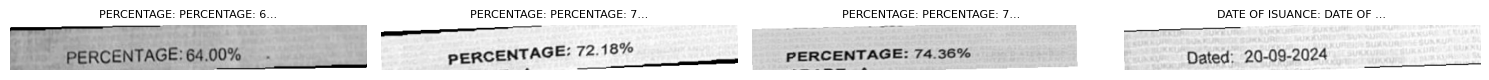

In [33]:
# samples from your training dataset
num_samples = 4
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    img_tensor, label_tensor = train_dataset[i]

    # Convert tensor back to numpy image
    img_np = img_tensor.squeeze(0).numpy()  # remove channel dimension
    img_np = (img_np * 0.5 + 0.5)  # undo normalization

    # Decode the label
    decoded_text = decode_indices(label_tensor.tolist())

    axes[i].imshow(img_np, cmap="gray")
    axes[i].set_title(decoded_text[:25] + "..." if len(decoded_text) > 25 else decoded_text, fontsize=8)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


### **5. Build CRNN Model**

Build a Convolutional Recurrent Neural Network (CRNN) for OCR.

* **CNN** layers extract visual features from images.

* **BiLSTM** layers capture sequential patterns in the extracted features.

* Fully connected layer outputs class probabilities (including the **CTC** blank).

In [18]:
class CRNN(nn.Module):
    def __init__(self, num_classes, hidden_size=256):
        super(CRNN, self).__init__()

        # Combine Conv layers
        self.cnn = nn.Sequential(
            # Conv1
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            # Conv2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            # Conv3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),

            # Conv4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.MaxPool2d((2, 1), (2, 1)),
        )

        # LSTM
        self.lstm = nn.LSTM(
            input_size=512 * 4,
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )

        # Fully connected (2 directions → hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, num_classes + 1)  # +1 for CTC blank

    def forward(self, x):
        # CNN
        x = self.cnn(x)
        b, c, h, w = x.size()

        # Reshape for LSTM (sequence length = width)
        x = x.permute(0, 3, 1, 2).contiguous().view(b, w, c * h)

        # LSTM
        x, _ = self.lstm(x)

        # Final Layer
        x = self.fc(x)

        return x


####  **Model Initialization & Training Configuration**

In [19]:
# Basic training settings
EPOCHS = 40
LR = 5e-4
SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset_/crnn_checkpoint_train.pth"

num_classes = len(vocab)

crnn_model = CRNN(num_classes).to(DEVICE)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(crnn_model.parameters(), lr=LR)

#### **Model Summary**

In [20]:
# Print Model Summary
summary(
    crnn_model,
    input_size=(1, 1, IMG_HEIGHT, IMG_WIDTH),  # batch, channel, H, W
    depth=4,
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    col_width=20,
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Kernel Shape
CRNN                                     [1, 1, 64, 512]      [1, 128, 45]         --                   --
├─Sequential: 1-1                        [1, 1, 64, 512]      [1, 512, 4, 128]     --                   --
│    └─Conv2d: 2-1                       [1, 1, 64, 512]      [1, 64, 64, 512]     640                  [3, 3]
│    └─BatchNorm2d: 2-2                  [1, 64, 64, 512]     [1, 64, 64, 512]     128                  --
│    └─ReLU: 2-3                         [1, 64, 64, 512]     [1, 64, 64, 512]     --                   --
│    └─MaxPool2d: 2-4                    [1, 64, 64, 512]     [1, 64, 32, 256]     --                   2
│    └─Conv2d: 2-5                       [1, 64, 32, 256]     [1, 128, 32, 256]    73,856               [3, 3]
│    └─BatchNorm2d: 2-6                  [1, 128, 32, 256]    [1, 128, 32, 256]    256                  --
│    └─ReLU: 2-7    

### **6. Train Model**

#### **Training and Validation Functions**

This section defines the core training and validation loops for the CRNN model:

- **`train_epoch()`** — Performs one full training pass:
  - Computes predictions and CTC loss.
  - Backpropagates gradients and updates weights.
  - Returns the average training loss per epoch.

- **`validate_epoch()`** — Evaluates the model on the validation set:
  - Computes predictions without gradient updates.
  - Returns the average validation loss per epoch.


In [21]:
# Load Parameters
start_epoch, train_losses, val_losses, train_accs, val_accs = load_checkpoint(
    SAVE_PATH, crnn_model, optimizer, reset=False
)

# Train
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for images, targets, lengths in dataloader:
        images, targets, lengths = images.to(DEVICE), targets.to(DEVICE), lengths.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(images)
        B, T, C = outputs.size()
        input_lengths = torch.full((B,), T, dtype=torch.long).to(DEVICE)
        log_probs = F.log_softmax(outputs, dim=2).permute(1, 0, 2)
        loss = criterion(log_probs, targets, input_lengths, lengths)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# Validation
def validate_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets, lengths in dataloader:
            images, targets, lengths = images.to(DEVICE), targets.to(DEVICE), lengths.to(DEVICE)
            outputs = model(images)
            B, T, C = outputs.size()
            input_lengths = torch.full((B,), T, dtype=torch.long).to(DEVICE)
            log_probs = F.log_softmax(outputs, dim=2).permute(1, 0, 2)
            loss = criterion(log_probs, targets, input_lengths, lengths)
            total_loss += loss.item()
    return total_loss / len(dataloader)


🔄 Loaded checkpoint — resumed from epoch 44


#### **Training Loop**

This cell trains the CRNN model over multiple epochs:

- **Iterates over epochs** from `start_epoch` to `EPOCHS`.  
- **Train & validate** each epoch, recording `train_loss` and `val_loss`.  
- **Compute accuracy** on training and validation sets.  
- **Prints summary** after each epoch for quick monitoring.  
- **Saves checkpoint** (`model + optimizer + history`) to resume training if needed.  


In [ ]:
# Training Loop
for epoch in range(start_epoch, EPOCHS):
    train_loss = train_epoch(crnn_model, train_loader, optimizer, criterion)
    val_loss   = validate_epoch(crnn_model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_acc = compute_accuracy(crnn_model, train_dataset, DEVICE)
    val_acc   = compute_accuracy(crnn_model, test_dataset, DEVICE)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"\nEpoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    save_checkpoint(
        SAVE_PATH,
        crnn_model,
        optimizer,
        epoch,
        train_losses,
        val_losses,
        train_accs,
        val_accs
    )


Epoch 41/50 | Train Loss: 0.0245 | Val Loss: 0.0529
Train Acc: 88.72% | Val Acc: 81.91%

Epoch 42/50 | Train Loss: 0.0219 | Val Loss: 0.0448
Train Acc: 89.57% | Val Acc: 83.96%

Epoch 43/50 | Train Loss: 0.0204 | Val Loss: 0.0447
Train Acc: 91.20% | Val Acc: 83.28%

Epoch 44/50 | Train Loss: 0.0231 | Val Loss: 0.0595
Train Acc: 81.79% | Val Acc: 76.45%

Epoch 45/50 | Train Loss: 0.0249 | Val Loss: 0.0460
Train Acc: 90.56% | Val Acc: 84.30%

Epoch 46/50 | Train Loss: 0.0180 | Val Loss: 0.0407
Train Acc: 92.52% | Val Acc: 85.67%

Epoch 47/50 | Train Loss: 0.0155 | Val Loss: 0.0447
Train Acc: 92.09% | Val Acc: 84.64%

Epoch 48/50 | Train Loss: 0.0134 | Val Loss: 0.0422
Train Acc: 93.97% | Val Acc: 86.69%

Epoch 49/50 | Train Loss: 0.0120 | Val Loss: 0.0434
Train Acc: 93.16% | Val Acc: 85.67%

Epoch 50/50 | Train Loss: 0.0132 | Val Loss: 0.0444
Train Acc: 92.39% | Val Acc: 86.35%


#### **7. Plot learning curve**
**Plots loss curves** to visualize training progress and check for overfitting or underfitting.


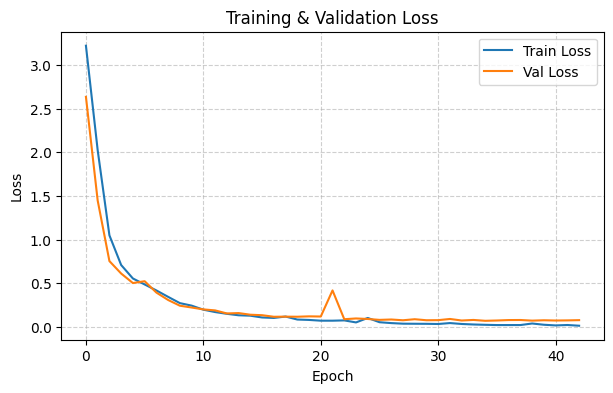

In [22]:
# Plot Loss
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True, ls='--', alpha=0.6)
plt.show()

### **8. Apply cross-validation on the val dataset to tune hyperparameters**

##### **Cross-Validation Hyperparameter Search (K-Fold)**

This block performs a small grid search to find the best hyperparameters for the CRNN model using **3-fold cross-validation on the validation dataset**.  
For each combination of learning rate, batch size, and hidden size:

1. Split the validation set into 3 folds.
2. Train the model on 2 folds and validate on the remaining fold.
3. Repeat for all folds and compute the **average validation loss**.
4. Track which hyperparameter set gives the **lowest average loss**.

At the end, it prints the **best hyperparameters** found.

In [ ]:

# Hyperparameters to search
param_grid = {
    "lr": [1e-4, 3e-4],
    "batch_size": [32, 64],
    "hidden_size": [128, 256],
}

# Kfold (Split data in 3 folds)
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
best_loss, best_params = float("inf"), None
EPOCHS_CV = 20

print("Running Cross-Validation on Validation Set...\n")

# Loop on the hyperparameters dictionary
for lr in param_grid["lr"]:
    for bs in param_grid["batch_size"]:
        for hidden in param_grid["hidden_size"]:

            fold_losses = []
            # Loop on Folds
            for fold, (tr_idx, va_idx) in enumerate(kfold.split(val_dataset)):
                tr_set = Subset(val_dataset, tr_idx)
                va_set = Subset(val_dataset, va_idx)

                # put in the dataloader
                tr_loader = DataLoader(tr_set, batch_size=bs, shuffle=True, collate_fn=collate_fn)
                va_loader = DataLoader(va_set, batch_size=bs, shuffle=False, collate_fn=collate_fn)

                # Apply model
                model_cv = CRNN(num_classes=num_classes, hidden_size=hidden).to(DEVICE)
                optim = torch.optim.Adam(model_cv.parameters(), lr=lr)
                crit = nn.CTCLoss(blank=0)

                for ep in range(EPOCHS_CV): # Train on epoch
                    train_epoch(model_cv, tr_loader, optim, crit)

                loss = validate_epoch(model_cv, va_loader, crit) # validate
                fold_losses.append(loss)

                print(f"Fold {fold+1}: lr={lr}, bs={bs}, hidden={hidden}, loss={loss:.4f}")

            avg_loss = sum(fold_losses) / len(fold_losses)
            print(f"Avg Loss → lr={lr}, bs={bs}, hidden={hidden} = {avg_loss:.4f}\n")

            if avg_loss < best_loss:
                best_loss = avg_loss
                best_params = {"lr": lr, "batch_size": bs, "hidden_size": hidden}

print("Best Hyperparameters:", best_params)


Running Cross-Validation on Validation Set...

Fold 1: lr=0.0001, bs=32, hidden=128, loss=3.2398
Fold 2: lr=0.0001, bs=32, hidden=128, loss=3.1579
Fold 3: lr=0.0001, bs=32, hidden=128, loss=3.2035
Avg Loss → lr=0.0001, bs=32, hidden=128 = 3.2004

Fold 1: lr=0.0001, bs=32, hidden=256, loss=3.0789
Fold 2: lr=0.0001, bs=32, hidden=256, loss=2.9963
Fold 3: lr=0.0001, bs=32, hidden=256, loss=3.0603
Avg Loss → lr=0.0001, bs=32, hidden=256 = 3.0452

Fold 1: lr=0.0001, bs=64, hidden=128, loss=3.3276
Fold 2: lr=0.0001, bs=64, hidden=128, loss=3.3048
Fold 3: lr=0.0001, bs=64, hidden=128, loss=3.3075
Avg Loss → lr=0.0001, bs=64, hidden=128 = 3.3133

Fold 1: lr=0.0001, bs=64, hidden=256, loss=3.2363
Fold 2: lr=0.0001, bs=64, hidden=256, loss=3.2036
Fold 3: lr=0.0001, bs=64, hidden=256, loss=3.2056
Avg Loss → lr=0.0001, bs=64, hidden=256 = 3.2152

Fold 1: lr=0.0003, bs=32, hidden=128, loss=3.1046
Fold 2: lr=0.0003, bs=32, hidden=128, loss=3.0454
Fold 3: lr=0.0003, bs=32, hidden=128, loss=3.1435
Avg

#### **Final Training Using Best Hyperparameters**

This block loads the CRNN model using the best hyperparameters found during cross-validation.  
It then:

1. Builds DataLoader with tuned batch size.

2. Loads checkpoint and resumes training.


In [24]:
# Model
crnn_tuned_model = CRNN(num_classes=num_classes, hidden_size=best_params["hidden_size"]).to(DEVICE)
# Optimizer
optimizer = torch.optim.Adam(crnn_tuned_model.parameters(), lr=best_params["lr"])

# Train loader
train_loader = DataLoader(
    train_dataset,
    batch_size=best_params["batch_size"],
    shuffle=True,
    collate_fn=collate_fn
)

# Path to store final trained model progress
FINAL_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset_/crnn_checkpoint_final.pth"
EPOCHS = 45

# Load checkpoint
start_epoch, train_losses, val_losses, train_accs, val_accs = load_checkpoint(FINAL_PATH, crnn_tuned_model, optimizer)

# Continue training from checkpoint
for epoch in range(start_epoch, EPOCHS):
    train_loss = train_epoch(crnn_tuned_model, train_loader, optimizer, criterion)
    val_loss   = validate_epoch(crnn_tuned_model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Calcuate Accuracy
    train_acc = compute_accuracy(crnn_tuned_model, train_dataset, DEVICE)
    val_acc   = compute_accuracy(crnn_tuned_model, val_dataset, DEVICE)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"\nEpoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    # Save checkpoint every epoch
    save_checkpoint(
        FINAL_PATH,
        crnn_tuned_model,
        optimizer,
        epoch,
        train_losses,
        val_losses,
        train_accs,
        val_accs
    )

print("\n Final retrained model ready for test prediction")


🔄 Loaded checkpoint — resumed from epoch 44

 Final retrained model ready for test prediction


### **10. Prediction of test data**

Character Accuracy: 0.9738515901060071
String Accuracy(Whole Feild): 0.9249146757679181
CER (Character Error Rate): 0.012720848056537103

Field-Level Accuracy:
  NAME: 0.985
  PERCENTAGE: 0.880
  GROUP: 1.000
  DATE OF ISSUANCE: 0.847

Plotting ROC–AUC Curve...


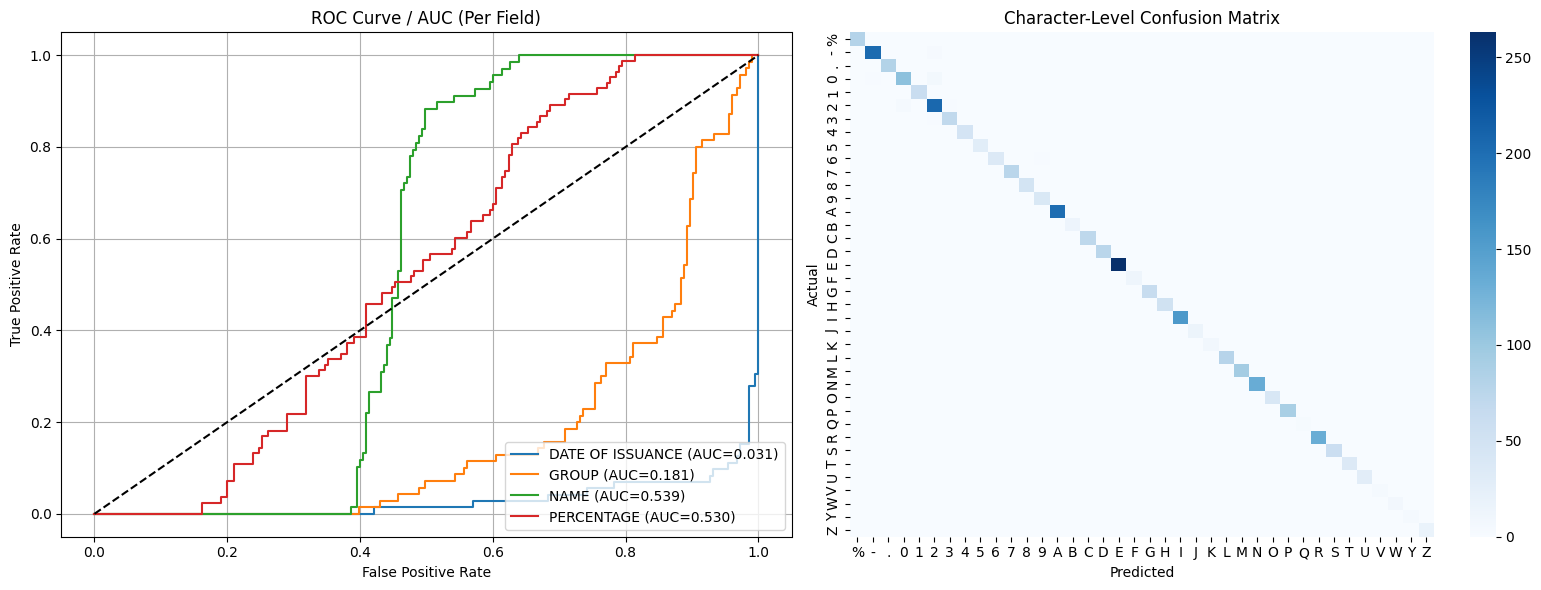

In [32]:
# Test Mode
crnn_tuned_model.eval()

gts, preds, fields = [], [], []

y_true = []      # field class ids
y_scores = []    # probability scores per class

with torch.no_grad():
    for i in range(len(test_dataset.df)):

        img, _ = test_dataset[i]
        image = img.unsqueeze(0).to(DEVICE).float()

        # Raw CRNN output
        logits = crnn_tuned_model(image)       # [1, T, C]
        log_probs = F.log_softmax(logits, dim=2)

        # Text prediction
        pred = decode_predictions(log_probs.cpu())[0].upper().strip()

        # Ground truth
        row = test_dataset.df.iloc[i]
        field = str(row.get("label", "")).upper().strip()
        gt = str(row.get("text", "")).upper().strip()

        # Remove FIELD:
        gt = re.sub(rf"^{field}\s*[:\-]?\s*", "", gt).strip()
        pred = re.sub(rf"^{field}\s*[:\-]?\s*", "", pred).strip()

        # Clean
        gt = re.sub(r"[^A-Z0-9%:\-\.]", "", gt)
        pred = re.sub(r"[^A-Z0-9%:\-\.]", "", pred)

        # Save for normal OCR evaluation
        gts.append(gt)
        preds.append(pred)
        fields.append(field)

        # ROC–AUC PART

        # Ground-truth class index
        class_id = field_to_idx[field]
        y_true.append(class_id)

        # Convert CRNN logits into CLASS probabilities
        char_probs = torch.exp(log_probs).mean(dim=1).cpu().numpy()[0]

        # Limit to number of field classes
        C = len(field_names)
        class_probs = char_probs[:C]

        y_scores.append(class_probs)


# Print Metrics
print("Character Accuracy:", character_accuracy(gts, preds))
print("String Accuracy(Whole Feild):", string_accuracy(gts, preds))
print("CER (Character Error Rate):", CER(gts, preds))

print("\nField-Level Accuracy:")
for f, acc in field_accuracy(fields, gts, preds).items():
    print(f"  {f}: {acc:.3f}")

print("\nPlotting ROC–AUC Curve...")

# Roc , Auc & confusion matrix
plot_roc_and_confusion(
    gts=gts,
    y_true=y_true,
    y_scores=y_scores,
    preds=preds,
    classes=field_names
)

## **Test**

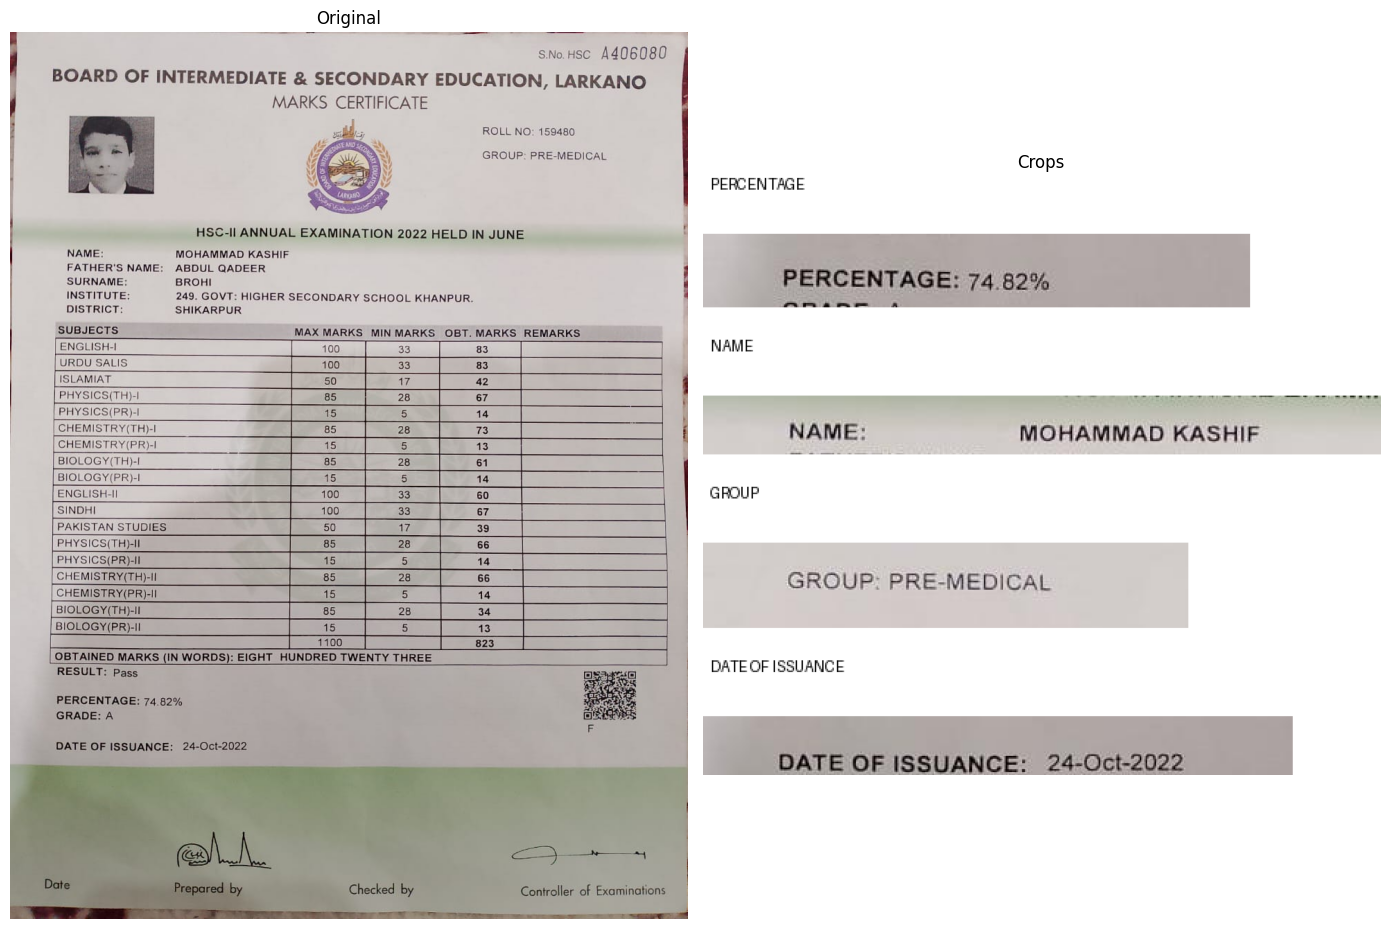


Final Recognized Fields:
PERCENTAGE: 74.82%
NAME: MOHAMMAD KASHIF
GROUP: PRE-MEDICAL
DATE OF ISSUANCE: 24-OCT-2022


In [31]:

# Paths & labels
image_path = "/content/MarksSheet.jpg"
labels = ['DATE OF ISSUANCE', 'GROUP', 'NAME', 'PERCENTAGE']

# Run YOLO crop
crops = detect_and_crop(image_path, yolo_best_model, "/content/crops", conf=0.4)

# Build combined visualization
original, combined = visualize_crops_with_labels(image_path, crops, labels)

# OCR predictions
crnn_tuned_model.eval()
preds = {}

with torch.no_grad():
    for crop_path, cls in crops:
        # Load image and apply new transform
        img = Image.open(crop_path).convert('L')  # grayscale
        img_t = test_transform(img).unsqueeze(0).float().to(DEVICE)

        # CRNN prediction
        logits = crnn_tuned_model(img_t)
        pred_text = decode_predictions(logits.cpu())[0]

        # Map prediction to field label
        preds[labels[cls]] = pred_text


# Display Results
plt.figure(figsize=(14, 12))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(combined)
plt.title("Crops")
plt.axis("off")
plt.tight_layout()
plt.show()


# Print final OCR outputs
print("\nFinal Recognized Fields:")
for field_name, text in preds.items():
    print(f"{text}")